In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<h4>XGBoost</h4>
https://xgboost.readthedocs.io/en/latest/ <br>
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=api#module-xgboost.sklearn <br>
https://www.lfd.uci.edu/~gohlke/pythonlibs <br>

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

<h4>학습데이터 로드</h4>

In [4]:
ls "./DACON"

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON 디렉터리

2020-09-27  오후 09:40    <DIR>          .
2020-09-27  오후 09:40    <DIR>          ..
2020-09-10  오후 12:55                43 .gitattributes
2020-09-25  오전 10:56    <DIR>          .ipynb_checkpoints
2020-09-27  오후 07:22       296,271,132 03pandasP.csv
2020-09-19  오후 08:17        11,060,442 EDA_train_Inhoinno(ing).ipynb
2020-09-10  오후 12:42       132,988,145 feature.csv
2020-09-25  오전 10:59       129,839,372 feature_train_file.csv
2020-09-10  오후 12:36         2,897,812 pandasdemo.ipynb
2020-09-10  오후 12:42           800,010 sample_submission.csv
2020-09-10  오후 12:42        18,936,246 test.csv
2020-09-27  오후 09:40        55,703,747 train.csv
2020-09-27  오후 09:36       172,560,400 train_npd.csv
2020-09-10  오후 12:37    <DIR>          단국대천체모형
              10개 파일         821,057,349 바이트
               4개 디렉터리  111,616,532,480 바이트 남음


In [5]:
data_dir = Path('./DACON')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
submission = pd.read_csv("./sample_submission.csv")
seed = 42


<h4> Train/Test 데이터 분석하기 </h4>

In [6]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
print(train.info())
print(test.info())
print(train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         320000 non-null  int64  
 1   u          320000 non-null  float64
 2   g          320000 non-null  float64
 3   r          320000 non-null  float64
 4   i          320000 non-null  float64
 5   z          320000 non-null  float64
 6   redshift   320000 non-null  float64
 7   dered_u    320000 non-null  float64
 8   dered_g    320000 non-null  float64
 9   dered_r    320000 non-null  float64
 10  dered_i    320000 non-null  float64
 11  dered_z    320000 non-null  float64
 12  nObserve   320000 non-null  int64  
 13  nDetect    320000 non-null  int64  
 14  airmass_u  320000 non-null  float64
 15  airmass_g  320000 non-null  float64
 16  airmass_r  320000 non-null  float64
 17  airmass_i  320000 non-null  float64
 18  airmass_z  320000 non-null  float64
 19  class      320000 non-n

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1100e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8100e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3200e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         80000 non-null  int64  
 1   u          80000 non-null  float64
 2   g          80000 non-null  float64
 3   r          80000 non-null  float64
 4   i          80000 non-null  float64
 5   z          80000 non-null  float64
 6   redshift   80000 non-null  float64
 7   dered_u    80000 non-null  float64
 8   dered_g    80000 non-null  float64
 9   dered_r    80000 non-null  float64
 10  dered_i    80000 non-null  float64
 11  dered_z    80000 non-null  float64
 12  nObserve   80000 non-null  int64  
 13  nDetect    80000 non-null  int64  
 14  airmass_u  80000 non-null  float64
 15  airmass_g  80000 non-null  float64
 16  airmass_r  80000 non-null  float64
 17  airmass_i  80000 non-null  float64
 18  airmass_z  80000 non-null  float64
dtypes: float64(16), int64(3)
memory usage: 11.6 MB

In [8]:
df = test
df['d_dered_u'] = df['dered_u'] - df['u']
df['d_dered_g'] = df['dered_g'] - df['g']
df['d_dered_r'] = df['dered_r'] - df['r']
df['d_dered_i'] = df['dered_i'] - df['i']
df['d_dered_z'] = df['dered_z'] - df['z']
df['d_dered_rg'] = df['dered_r'] - df['dered_g']
df['d_dered_ig'] = df['dered_i'] - df['dered_g']
df['d_dered_zg'] = df['dered_z'] - df['dered_g']
df['d_dered_ri'] = df['dered_r'] - df['dered_i']
df['d_dered_rz'] = df['dered_r'] - df['dered_z']
df['d_dered_iz'] = df['dered_i'] - df['dered_z']
df['d_obs_det'] = df['nObserve'] - df['nDetect']

# 나누기 시작
df['n_dered_u'] = df['dered_u'] / df['u'] * 100
df['n_dered_g'] = df['dered_g'] / df['g']* 100
df['n_dered_r'] = df['dered_r'] / df['r']* 100
df['n_dered_i'] = df['dered_i'] / df['i']* 100
df['n_dered_z'] = df['dered_z'] / df['z']* 100
df['n_dered_rg'] = df['dered_r'] / df['dered_g']* 100
df['n_dered_ig'] = df['dered_i'] / df['dered_g']* 100
df['n_dered_zg'] = df['dered_z'] / df['dered_g']* 100
df['n_dered_ri'] = df['dered_r'] / df['dered_i']* 100
df['n_dered_rz'] = df['dered_r'] / df['dered_z']* 100
df['n_dered_iz'] = df['dered_i'] / df['dered_z']* 100
df['n_obs_det'] = df['nObserve'] / df['nDetect']

print(df.shape)
df.describe()

(80000, 43)


,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det
count,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,8.0000e+04,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000
mean,359999.5000,19.8598,18.4371,17.7397,17.3065,17.1490,6.0083e-02,19.6350,18.2638,17.6193,17.2178,16.8702,6.3499,6.1578,1.1760,1.1767,1.1753,1.1756,1.1763,-0.2249,-0.1733,-0.1204,-0.0887,-0.2787,-0.6444,-1.0460,-1.3935,0.4015,0.7491,0.3476,0.1922,98.8345,99.0661,99.3087,99.4926,99.5875,96.5628,94.4637,92.3575,102.3235,103.6609,101.3184,1.0328
std,23094.1551,1.9543,1.7030,1.4786,1.3207,24.6431,3.4684e-01,1.9210,1.6657,1.4760,1.3324,35.4367,8.8728,8.5509,0.1164,0.1182,0.1148,0.1156,0.1173,0.7107,0.6235,0.3967,0.2865,60.0184,0.5555,0.8945,35.4120,0.5405,35.4029,35.3975,1.0084,27.1880,5.6866,4.1601,2.0523,9.7664,2.7234,4.2880,265.5369,2.9235,15.3386,6.8694,0.3678
min,320000.0000,-0.3385,-51.1753,-5.4387,5.3267,-39.5272,-3.0149e+01,-30.6337,-18.6560,-8.7560,-3.6973,-9999.0000,1.0000,1.0000,1.0001,1.0001,1.0002,1.0002,1.0001,-54.8323,-69.3194,-29.3532,-21.8010,-16975.3922,-13.0229,-13.4431,-10012.3326,-11.5039,-12.6504,-12.4170,-1.0000,-7472.6935,-1172.2439,-779.1281,-20.4227,-2486.7721,11.6087,-39.9525,-74996.5123,-29.0563,-4055.9057,-1712.6188,0.9565
25%,339999.7500,18.7273,17.4780,16.8820,16.5255,16.2882,3.3645e-05,18.5709,17.3522,16.7906,16.4562,16.2310,1.0000,1.0000,1.0881,1.0883,1.0877,1.0879,1.0882,-0.2340,-0.1650,-0.1138,-0.0847,-0.0700,-0.8136,-1.2357,-1.5288,0.2149,0.3083,0.0849,0.0000,98.8066,99.0987,99.3557,99.5093,99.5886,95.4533,93.0819,91.4347,101.2521,101.7929,100.4935,1.0000
50%,359999.5000,19.4261,18.1451,17.5299,17.1560,16.9212,4.7115e-02,19.2674,18.0247,17.4487,17.0912,16.8733,2.0000,2.0000,1.1794,1.1793,1.1794,1.1794,1.1793,-0.1343,-0.1017,-0.0704,-0.0523,-0.0406,-0.5848,-0.9203,-1.1220,0.3388,0.5365,0.2023,0.0000,99.3007,99.4401,99.5991,99.6949,99.7570,96.7055,94.8290,93.7027,102.0049,103.2075,101.2098,1.0000
75%,379999.2500,20.4344,19.0793,18.4345,18.0080,17.7333,9.4769e-02,20.1999,18.8948,18.2952,17.9109,17.6578,5.0000,5.0000,1.2278,1.2262,1.2294,1.2289,1.2269,-0.0709,-0.0634,-0.0441,-0.0326,-0.0210,-0.3828,-0.6030,-0.6987,0.4273,0.7159,0.2968,0.0000,99.6280,99.6485,99.7468,99.8083,99.8738,97.8332,96.6028,96.0660,102.5681,104.3847,101.8181,1.0000
max,399999.0000,56.8471,94.3591,46.6913,33.0259,6976.3922,4.6390e+01,30.8899,30.9529,31.6536,30.9478,28.6441,44.0000,42.0000,2.0502,2.0797,2.0216,2.0358,2.0648,25.6354,76.1173,30.1964,18.9817,62.2878,14.8045,14.9587,18.8719,14.2138,10011.6575,10011.3000,37.0000,932.4037,711.7276,250.2154,456.3481,822.9138,231.1044,286.5140,332.0927,236.8248,214.1411,209.6091,38.0000


In [9]:
df0 = train
df0['d_dered_u'] = df0['dered_u'] - df0['u']
df0['d_dered_g'] = df0['dered_g'] - df0['g']
df0['d_dered_r'] = df0['dered_r'] - df0['r']
df0['d_dered_i'] = df0['dered_i'] - df0['i']
df0['d_dered_z'] = df0['dered_z'] - df0['z']
df0['d_dered_rg'] = df0['dered_r'] - df0['dered_g']
df0['d_dered_ig'] = df0['dered_i'] - df0['dered_g']
df0['d_dered_zg'] = df0['dered_z'] - df0['dered_g']
df0['d_dered_ri'] = df0['dered_r'] - df0['dered_i']
df0['d_dered_rz'] = df0['dered_r'] - df0['dered_z']
df0['d_dered_iz'] = df0['dered_i'] - df0['dered_z']
df0['d_obs_det'] = df0['nObserve'] - df0['nDetect']

# 나누기 시작
df0['n_dered_u'] = df0['dered_u'] / df0['u'] * 100
df0['n_dered_g'] = df0['dered_g'] / df0['g']* 100
df0['n_dered_r'] = df0['dered_r'] / df0['r']* 100
df0['n_dered_i'] = df0['dered_i'] / df0['i']* 100
df0['n_dered_z'] = df0['dered_z'] / df0['z']* 100
df0['n_dered_rg'] = df0['dered_r'] / df0['dered_g']* 100
df0['n_dered_ig'] = df0['dered_i'] / df0['dered_g']* 100
df0['n_dered_zg'] = df0['dered_z'] / df0['dered_g']* 100
df0['n_dered_ri'] = df0['dered_r'] / df0['dered_i']* 100
df0['n_dered_rz'] = df0['dered_r'] / df0['dered_z']* 100
df0['n_dered_iz'] = df0['dered_i'] / df0['dered_z']* 100
df0['n_obs_det'] = df0['nObserve'] / df0['nDetect']

print(df0.shape)
df0.describe()

(320000, 44)


,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,159999.5000,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,6.3327,6.1388,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163,-0.2236,-0.1498,-0.1203,-0.0219,-0.0059,-0.6117,-1.0747,-1.3578,0.4631,0.7462,0.2831,0.1939,98.9168,99.0760,99.3282,99.4855,99.6116,96.5620,94.2928,92.7875,102.2973,103.6893,101.3283,1.0325
std,92376.1874,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,8.8811,8.5516,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235,0.6967,13.3675,0.3630,28.0581,28.2757,17.7168,17.7284,30.6874,25.0468,35.4207,25.0444,1.0243,4.2179,4.4570,1.9197,2.3704,3.1883,3.9601,97.8706,169.2568,12.4126,8.6952,4.0781,0.3473
min,0.0000,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000,-66.3661,-51.2796,-46.9576,-26.3505,-1968.6898,-15.2991,-10017.1270,-10017.2590,-13.5664,-17.7428,-16.6637,-1.0000,-800.9068,-522.6582,-92.6614,-432.8007,-674.8493,-1591.2990,-55160.8707,-55455.8175,-6726.1169,-4055.9057,-1712.6188,0.9524
25%,79999.7500,18.7241,17.4749,16.8772,16.5239,16.2889,3.5600e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-0.8119,-1.2330,-1.5263,0.2136,0.3072,0.0844,0.0000,98.8040,99.0980,99.3564,99.5095,99.5882,95.4690,93.1021,91.4614,101.2432,101.7876,100.4901,1.0000
50%,159999.5000,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.5814,-0.9160,-1.1169,0.3376,0.5338,0.2009,0.0000,99.3012,99.4421,99.6003,99.6949,99.7573,96.7271,94.8543,93.7371,101.9965,103.1905,101.2022,1.0000
75%,239999.2500,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.3818,-0.6014,-0.6951,0.4266,0.7146,0.2965,0.0000,99.6289,99.6498,99.7480,99.8090,99.8753,97.8399,96.6126,96.0875,102.5633,104.3759,101.8148,1.0000
max,319999.0000,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000,42.2511,7556.3656,16.9807,13956.8178,13956.8178,10016.8146,21.8604,27.7746,10016.8280,10016.8755,10016.5565,40.0000,1113.2305,1981.2093,319.6338,896.7994,1072.3486,231.1044,286.5140,332.0927,236.8248,629.0700,332.2793,41.0000


In [10]:
df.drop(['airmass_z', 'airmass_i', 'airmass_r', 'airmass_g', 'd_dered_rg', 'd_dered_ri'], 
        axis=1, inplace=True)
df0.drop(['airmass_z', 'airmass_i', 'airmass_r', 'airmass_g', 'd_dered_rg', 'd_dered_ri'], 
        axis=1, inplace=True)
print(df.shape)
df.head()

(80000, 37)


,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det
0,320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,-0.0681,-0.0622,-0.0424,-0.0306,-0.0176,-0.8711,-1.0462,0.5221,0.1751,0,99.6443,99.6545,99.7573,99.8212,99.8962,97.0810,95.1482,94.1730,102.0314,103.0879,101.0355,1.0
1,320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,-3.6706,-2.8607,-1.9790,-1.4705,-1.0935,0.2062,0.3274,-0.2470,-0.1212,0,80.4141,83.3393,87.9103,90.8019,93.0483,100.5615,101.4413,102.2879,99.1328,98.3122,99.1722,1.0
2,320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,-0.1977,-0.1077,-0.0761,-0.0599,-0.0664,-1.0230,-1.2037,0.5771,0.1808,0,98.9756,99.3976,99.5580,99.6438,99.6011,96.4742,94.2442,93.2269,102.3662,103.4832,101.0912,1.0
3,320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,-0.1045,-0.0834,-0.0572,-0.0418,-0.0288,-0.3036,-0.3068,0.0802,0.0032,0,99.4218,99.5138,99.6619,99.7511,99.8288,98.6730,98.2219,98.2033,100.4592,100.4783,100.0190,1.0
4,320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,-0.0780,-0.0852,-0.0572,-0.0407,-0.0187,-0.8480,-1.0361,0.5129,0.1881,0,99.5626,99.4920,99.6469,99.7434,99.8804,96.8635,94.9160,93.7883,102.0518,103.2789,101.2024,1.0


In [11]:
df['nObserve_log'] = df['nObserve'].apply(np.log1p)
df['nDetect_log'] = df['nDetect'].apply(np.log1p)
df0['nObserve_log'] = df0['nObserve'].apply(np.log1p)
df0['nDetect_log'] = df0['nDetect'].apply(np.log1p)

In [12]:
test= df
train=df0

<h4> Train, Test 를 보면 train[g,i,z,dered_g, dered_i,dered_z] 가 Outlier가 있는걸 알수 있음 </h4>

In [13]:
train.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det,nObserve_log,nDetect_log
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,159999.5000,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,6.3327,6.1388,1.1758,1.1163,-0.2236,-0.1498,-0.1203,-0.0219,-0.0059,-1.0747,-1.3578,0.7462,0.2831,0.1939,98.9168,99.0760,99.3282,99.4855,99.6116,96.5620,94.2928,92.7875,102.2973,103.6893,101.3283,1.0325,1.4861,1.4702
std,92376.1874,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,8.8811,8.5516,0.1163,0.9235,0.6967,13.3675,0.3630,28.0581,28.2757,17.7284,30.6874,35.4207,25.0444,1.0243,4.2179,4.4570,1.9197,2.3704,3.1883,3.9601,97.8706,169.2568,12.4126,8.6952,4.0781,0.3473,0.9061,0.8959
min,0.0000,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,0.0000,-66.3661,-51.2796,-46.9576,-26.3505,-1968.6898,-10017.1270,-10017.2590,-17.7428,-16.6637,-1.0000,-800.9068,-522.6582,-92.6614,-432.8007,-674.8493,-1591.2990,-55160.8707,-55455.8175,-6726.1169,-4055.9057,-1712.6188,0.9524,0.6931,0.6931
25%,79999.7500,18.7241,17.4749,16.8772,16.5239,16.2889,3.5600e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0000,1.0000,1.0882,0.0000,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5263,0.3072,0.0844,0.0000,98.8040,99.0980,99.3564,99.5095,99.5882,95.4690,93.1021,91.4614,101.2432,101.7876,100.4901,1.0000,0.6931,0.6931
50%,159999.5000,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.0000,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000,99.3012,99.4421,99.6003,99.6949,99.7573,96.7271,94.8543,93.7371,101.9965,103.1905,101.2022,1.0000,1.0986,1.0986
75%,239999.2500,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,5.0000,5.0000,1.2275,2.0000,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000,99.6289,99.6498,99.7480,99.8090,99.8753,97.8399,96.6126,96.0875,102.5633,104.3759,101.8148,1.0000,1.7918,1.7918
max,319999.0000,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0000,42.2511,7556.3656,16.9807,13956.8178,13956.8178,21.8604,27.7746,10016.8755,10016.5565,40.0000,1113.2305,1981.2093,319.6338,896.7994,1072.3486,231.1044,286.5140,332.0927,236.8248,629.0700,332.2793,41.0000,3.8067,3.7612


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            80000 non-null  int64  
 1   u             80000 non-null  float64
 2   g             80000 non-null  float64
 3   r             80000 non-null  float64
 4   i             80000 non-null  float64
 5   z             80000 non-null  float64
 6   redshift      80000 non-null  float64
 7   dered_u       80000 non-null  float64
 8   dered_g       80000 non-null  float64
 9   dered_r       80000 non-null  float64
 10  dered_i       80000 non-null  float64
 11  dered_z       80000 non-null  float64
 12  nObserve      80000 non-null  int64  
 13  nDetect       80000 non-null  int64  
 14  airmass_u     80000 non-null  float64
 15  d_dered_u     80000 non-null  float64
 16  d_dered_g     80000 non-null  float64
 17  d_dered_r     80000 non-null  float64
 18  d_dered_i     80000 non-nu

<h4> 테스트 데이터의 경우 test[g,z,dered_z] 정도가 좀 불편함 </h4>
--> 겹치는 field는 g, z, dered_z 임

In [15]:
train[(train['class'] == 2)].describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det,nObserve_log,nDetect_log
count,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000
mean,160075.7694,19.2380,17.8746,17.2048,16.6790,16.3225,0.0918,19.0890,17.7590,17.1243,16.7084,16.3531,4.4425,4.3101,1.1671,2.0,-0.1490,-0.1155,-0.0805,0.0294,0.0306,-1.0507,-1.4059,0.7712,0.3553,0.1324,99.2414,99.3567,99.5379,99.6464,99.7289,96.4341,94.1004,92.1150,102.1127,103.5344,101.3948,1.0234,1.2781,1.2664
std,92382.9512,1.0715,1.0166,0.9897,60.4673,68.4103,0.0572,1.0298,0.9942,0.9645,25.2785,43.7612,7.2095,6.9031,0.1183,0.0,0.2400,0.1732,0.1771,35.1997,35.5522,25.2636,43.7540,43.7540,35.7249,0.8459,1.8875,1.2606,0.7376,1.5272,2.3130,1.4324,139.3677,241.2247,1.1046,1.7027,1.4647,0.2549,0.7566,0.7460
min,5.0000,3.7674,-12.4441,9.8544,-23955.8178,-23955.8178,-0.0008,12.2915,11.9272,11.1424,-9999.0000,-9999.0000,1.0000,1.0000,1.0019,2.0,-23.6245,-21.3197,-46.9576,-13.2341,-1968.6898,-10017.1270,-10017.2590,-10.5090,-11.9804,0.0000,50.7081,-201.3778,34.7899,-432.8007,-674.8493,56.9665,-55160.8707,-55455.8175,-0.1783,-0.1788,-0.1756,1.0000,0.6931,0.6931
25%,79986.5000,18.7004,17.3863,16.7497,16.3739,16.1151,0.0541,18.5697,17.2813,16.6761,16.3194,16.0736,1.0000,1.0000,1.0739,2.0,-0.1972,-0.1438,-0.0998,-0.0746,-0.0611,-1.1757,-1.4618,0.4686,0.1718,0.0000,98.9723,99.1938,99.4190,99.5554,99.6302,95.6893,93.3627,91.7397,101.7638,102.8059,101.0286,1.0000,0.6931,0.6931
50%,160092.0000,19.2525,17.9417,17.2981,16.9181,16.6660,0.0810,19.1208,17.8376,17.2253,16.8635,16.6262,2.0000,2.0000,1.1531,2.0,-0.1235,-0.0935,-0.0648,-0.0484,-0.0375,-0.9925,-1.2269,0.5959,0.2349,0.0000,99.3503,99.4741,99.6213,99.7107,99.7705,96.4316,94.3725,93.0494,102.1686,103.6242,101.4278,1.0000,1.0986,1.0986
75%,240184.5000,19.7410,18.3297,17.6502,17.2754,17.0488,0.1171,19.5932,18.2191,17.5765,17.2204,17.0073,3.0000,3.0000,1.2204,2.0,-0.0695,-0.0599,-0.0415,-0.0307,-0.0195,-0.7883,-0.9585,0.6984,0.2898,0.0000,99.6323,99.6612,99.7567,99.8159,99.8806,97.2174,95.5247,94.5650,102.4959,104.2974,101.7859,1.0000,1.3863,1.3863
max,319995.0000,47.9278,46.3383,72.0097,36.7897,52.6127,0.5659,30.7779,30.3180,31.8750,32.0162,27.4069,43.0000,41.0000,1.8639,2.0,20.5373,37.5039,14.1958,13956.8178,13956.8178,14.9771,9.8202,10016.8755,10016.5565,35.0000,645.1394,369.5474,244.0562,251.8857,210.0982,187.0696,187.8986,160.3761,162.9997,204.6887,205.5958,36.0000,3.7842,3.7377


Box로 보기

Text(0.5, 1.0, 'class vs d_dered_g')

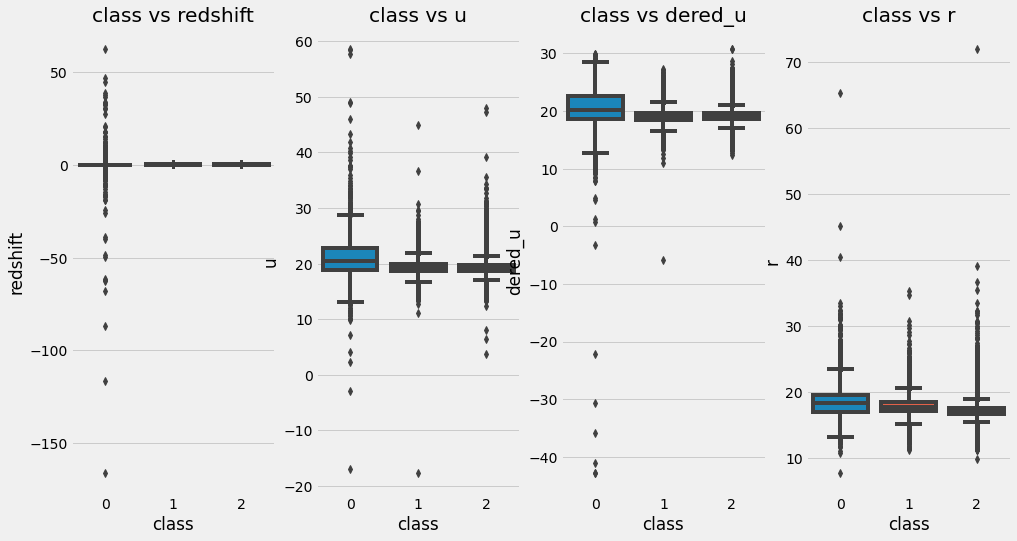

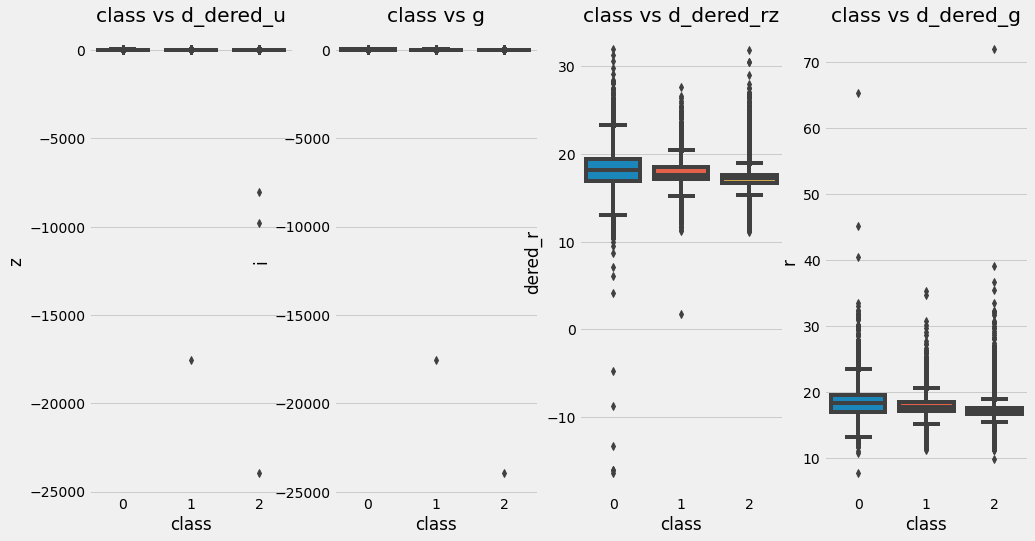

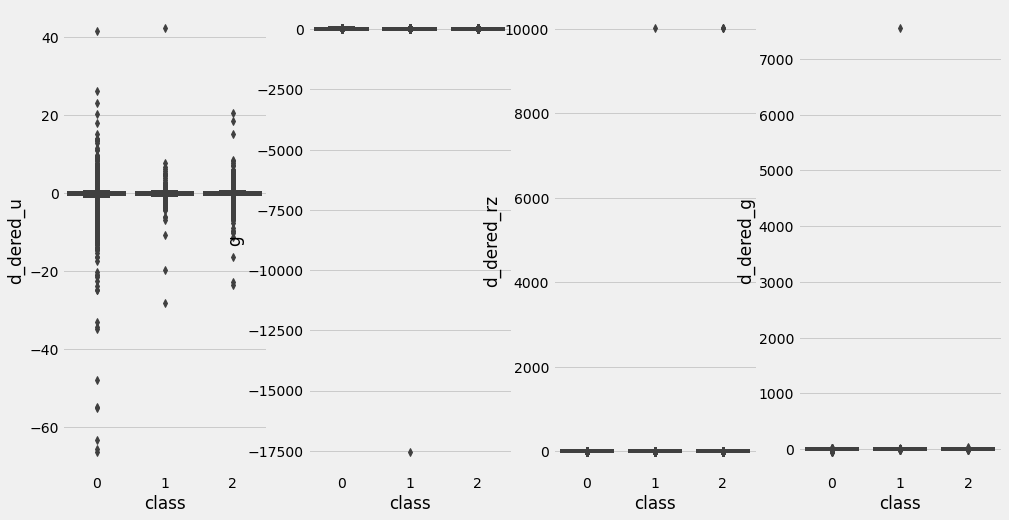

In [16]:
f , axes = plt.subplots(ncols = 4, figsize = (15,8))

sns.boxplot(x = 'class', y = 'redshift', data= train, ax= axes[0])
axes[0].set_title('class vs redshift')
sns.boxplot(x = 'class', y = 'u', data= train, ax= axes[1])
axes[1].set_title('class vs u')
sns.boxplot(x = 'class', y = 'dered_u', data= train, ax= axes[2])
axes[2].set_title('class vs dered_u')
sns.boxplot(x = 'class', y = 'r', data= train, ax= axes[3])
axes[3].set_title('class vs r')

p, axes1 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'z', data= train, ax= axes1[0])
axes1[0].set_title('class vs z')
sns.boxplot(x = 'class', y = 'i', data= train, ax= axes1[1])
axes1[1].set_title('class vs i')
sns.boxplot(x = 'class', y = 'dered_r', data= train, ax= axes1[2])
axes1[2].set_title('class vs dered_r')
sns.boxplot(x = 'class', y = 'r', data= train, ax= axes1[3])
axes1[3].set_title('class vs r')

k, axes2 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'd_dered_u', data= train, ax= axes2[0])
axes1[0].set_title('class vs d_dered_u')
sns.boxplot(x = 'class', y = 'g', data= train, ax= axes2[1])
axes1[1].set_title('class vs g')
sns.boxplot(x = 'class', y = 'd_dered_rz', data= train, ax= axes2[2])
axes1[2].set_title('class vs d_dered_rz')
sns.boxplot(x = 'class', y = 'd_dered_g', data= train, ax= axes2[3])
axes1[3].set_title('class vs d_dered_g')


<h3> Column 설정하기 </h3> 

In [17]:
target_col = 'class'
pred_col = 'pred'
num_cols = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['id', 'u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'nObserve', 'nDetect', 'airmass_u', 'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 'd_obs_det', 'n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z', 'n_dered_rg', 'n_dered_ig', 'n_dered_zg', 'n_dered_ri', 'n_dered_rz', 'n_dered_iz', 'n_obs_det', 'nObserve_log', 'nDetect_log']


cols_to_use 설정하기

In [18]:
num_col = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col and x != 'id' and x != 'airmass_u']
cols_to_use = ['redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z','airmass_u',
               'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 
               'd_obs_det', 'n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z', 
               'n_dered_rg', 'n_dered_ig', 'n_dered_zg', 'n_dered_ri', 'n_dered_rz', 'n_dered_iz',
               'n_obs_det', 'nObserve_log', 'nDetect_log']
#이 중 정규화를 했으면 좋겠는 열은 g, z, dered_z
#이외로 train에서는 i,dered_g, dered_i에서 Outlier가 있고
# test 에서는 g,z,dered_z
# Redshift의 경우 제일 영향이 많은 Column이므로 섣부른 정규화는 조심히 수행하자
cols_to_scale = ['g','z','dered_z']
cols_to_use


['redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'd_obs_det',
 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_rg',
 'n_dered_ig',
 'n_dered_zg',
 'n_dered_ri',
 'n_dered_rz',
 'n_dered_iz',
 'n_obs_det',
 'nObserve_log',
 'nDetect_log']

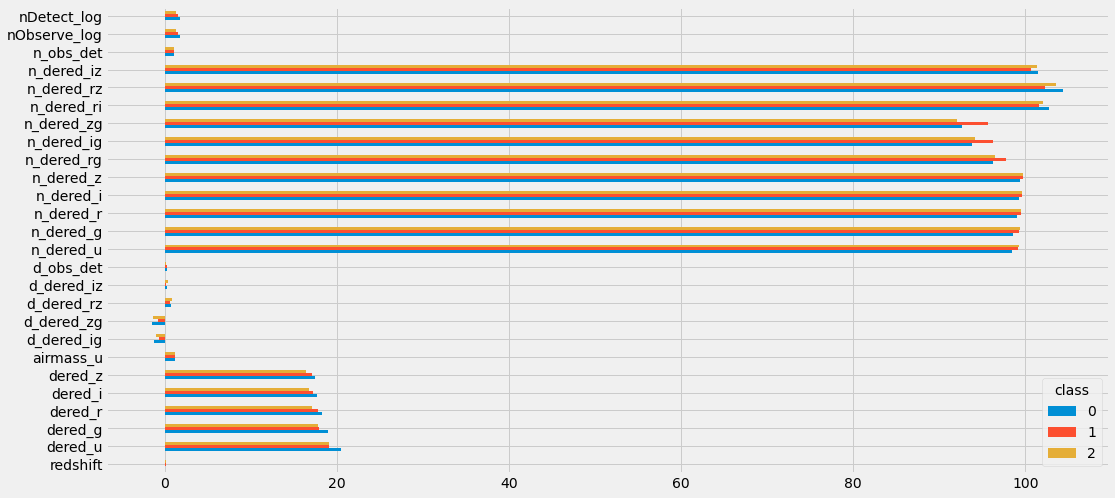

In [19]:
trn = train[cols_to_use+['class']]
trn.groupby('class').mean().T.plot(kind='barh')

<h1> 데이터 정규화 및 Outlier 처리</h1>

cols_to_scale에 정규화를 적용한 cols_scaled와 train_scaled를 생성해 보기

일반적인 정규화 <br>
    1. StandardScaler
    2. MinMaxScaler 최대 최소 스케일링
Outlier가 있을 때
    1. Z-score
    2. Tukey_fences
    3. Robust Scaler
     

<h4>> 내가 접근 해볼 것</h4>
1. Outlier를 아예 Train 에서 제거하고, 모델 학습을 시킨다     --> Model0 <br>
2. Outlier가 포함된 Train 에서 Scaler모델을 적용, 학습시킨다  --> Model1 <br>
3. Outlier를 아예 제거, 정규화(StandardScaler)를 적용해 본다  --> Model2

<h5> 1. Model0 </h5>

In [20]:
train[cols_to_use].describe()

,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det,nObserve_log,nDetect_log
count,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,1.1758,-1.0747,-1.3578,0.7462,0.2831,0.1939,98.9168,99.0760,99.3282,99.4855,99.6116,96.5620,94.2928,92.7875,102.2973,103.6893,101.3283,1.0325,1.4861,1.4702
std,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,0.1163,17.7284,30.6874,35.4207,25.0444,1.0243,4.2179,4.4570,1.9197,2.3704,3.1883,3.9601,97.8706,169.2568,12.4126,8.6952,4.0781,0.3473,0.9061,0.8959
min,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0001,-10017.1270,-10017.2590,-17.7428,-16.6637,-1.0000,-800.9068,-522.6582,-92.6614,-432.8007,-674.8493,-1591.2990,-55160.8707,-55455.8175,-6726.1169,-4055.9057,-1712.6188,0.9524,0.6931,0.6931
25%,3.5600e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0882,-1.2330,-1.5263,0.3072,0.0844,0.0000,98.8040,99.0980,99.3564,99.5095,99.5882,95.4690,93.1021,91.4614,101.2432,101.7876,100.4901,1.0000,0.6931,0.6931
50%,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,-0.9160,-1.1169,0.5338,0.2009,0.0000,99.3012,99.4421,99.6003,99.6949,99.7573,96.7271,94.8543,93.7371,101.9965,103.1905,101.2022,1.0000,1.0986,1.0986
75%,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,1.2275,-0.6014,-0.6951,0.7146,0.2965,0.0000,99.6289,99.6498,99.7480,99.8090,99.8753,97.8399,96.6126,96.0875,102.5633,104.3759,101.8148,1.0000,1.7918,1.7918
max,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,21.8604,27.7746,10016.8755,10016.5565,40.0000,1113.2305,1981.2093,319.6338,896.7994,1072.3486,231.1044,286.5140,332.0927,236.8248,629.0700,332.2793,41.0000,3.8067,3.7612


In [21]:
ids = train
show = ids[(ids['dered_g'] <-1000) | (ids['dered_i'] < -1000) | (ids['dered_z'] <-1000) & (ids['class'] == 0) ]
train_model0 = ids[(ids['dered_g'] >-1000) & (ids['dered_i'] > -1000) & (ids['dered_z'] >-1000)]
train_model0

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det,nObserve_log,nDetect_log
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1100e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,0,99.3995,99.6116,99.7139,99.7718,99.8190,93.5695,87.0387,83.4688,107.5034,112.1012,104.2768,1.0000,2.9444,2.9444
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,0,99.4305,99.5915,99.6950,99.7573,99.7398,95.7647,94.5141,93.7889,101.3232,102.1067,100.7733,1.0000,0.6931,0.6931
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,0,98.9352,99.1227,99.3803,99.5335,99.6485,98.4283,97.6741,97.5105,100.7722,100.9412,100.1677,1.0000,1.0986,1.0986
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8100e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,1,98.8037,99.0841,99.3379,99.4959,99.5953,95.6780,94.2843,93.1436,101.4783,102.7210,101.2246,1.3333,1.6094,1.3863
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3200e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,1,97.2109,98.7182,99.0580,99.2694,99.4065,92.3125,89.0204,87.4819,103.6982,105.5218,101.7586,1.0833,2.6391,2.5649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,319995,18.3656,17.2409,16.7739,16.4850,16.3404,5.1988e-02,18.1328,17.0406,16.6374,16.3861,16.2874,2,2,1.0930,2,-0.2328,-0.2002,-0.1365,-0.0989,-0.0530,-0.6546,-0.7532,0.3500,0.0986,0,98.7322,98.8386,99.1865,99.4000,99.6757,97.6338,96.1587,95.5797,101.5341,102.1491,100.6057,1.0000,1.0986,1.0986
319996,319996,18.6856,17.6658,17.1904,16.8169,16.6367,8.7261e-02,18.5207,17.5131,17.0871,16.7436,16.6017,2,2,1.0517,1,-0.1649,-0.1527,-0.1033,-0.0732,-0.0350,-0.7695,-0.9114,0.4854,0.1419,0,99.1175,99.1356,99.3989,99.5646,99.7899,97.5676,95.6063,94.7961,102.0514,102.9237,100.8547,1.0000,1.0986,1.0986
319997,319997,21.1890,18.4234,17.2956,16.9011,16.6841,-1.0100e-05,20.9890,18.3076,17.2152,16.8403,16.6355,31,30,1.1933,0,-0.2000,-0.1158,-0.0804,-0.0608,-0.0486,-1.4673,-1.6721,0.5796,0.2048,1,99.0561,99.3717,99.5350,99.6404,99.7088,94.0330,91.9853,90.8669,102.2261,103.4843,101.2308,1.0333,3.4657,3.4340
319998,319998,18.8472,17.3186,16.5057,16.1806,15.9116,-4.5200e-05,16.3900,15.4058,15.1823,15.1969,15.1793,1,1,1.1725,0,-2.4572,-1.9128,-1.3234,-0.9836,-0.7323,-0.2088,-0.2264,0.0029,0.0176,0,86.9625,88.9551,91.9819,93.9209,95.3979,98.5493,98.6443,98.5302,99.9037,100.0194,100.1158,1.0000,0.6931,0.6931


In [22]:
train_model0.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det,nObserve_log,nDetect_log
count,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,3.2000e+05,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000
mean,159999.9526,19.8524,18.4318,17.7358,17.3041,17.0608,5.8307e-02,19.6289,18.2584,17.6154,17.2149,16.9945,6.3327,6.1388,1.1758,1.1163,-0.2236,-0.1734,-0.1203,-0.0891,-0.0663,-1.0434,-1.2639,0.6210,0.2205,0.1939,98.9168,99.0761,99.3282,99.4858,99.6119,96.5622,94.4654,93.3052,102.2979,103.6906,101.3289,1.0325,1.4861,1.4702
std,92376.5460,1.9456,1.6612,1.4663,1.3226,1.3370,5.7546e-01,1.9236,1.6681,1.4730,1.3294,1.3263,8.8812,8.5517,0.1163,0.9235,0.6967,0.4989,0.3630,0.2960,0.3156,0.8898,1.1140,0.7714,0.4587,1.0243,4.2179,4.4564,1.9197,2.3670,3.1855,3.9565,6.1274,7.8165,12.4100,8.6875,4.0702,0.3473,0.9061,0.8960
min,0.0000,-17.6875,-12.4441,7.7314,-23.9024,-9.2548,-1.6605e+02,-42.8375,-30.3208,-16.3802,-8.9412,-3.7059,1.0000,1.0000,1.0001,0.0000,-66.3661,-51.2796,-46.9576,-26.3505,-30.5841,-15.0278,-17.2340,-17.7428,-16.6637,-1.0000,-800.9068,-522.6582,-92.6614,-432.8007,-674.8493,-1591.2990,-2430.4263,-3153.1178,-6726.1169,-4055.9057,-1712.6188,0.9524,0.6931,0.6931
25%,79999.7500,18.7241,17.4749,16.8772,16.5239,16.2889,3.5600e-05,18.5636,17.3484,16.7871,16.4531,16.2341,1.0000,1.0000,1.0882,0.0000,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5262,0.3072,0.0844,0.0000,98.8040,99.0980,99.3564,99.5095,99.5883,95.4690,93.1021,91.4614,101.2432,101.7876,100.4901,1.0000,0.6931,0.6931
50%,160000.5000,19.4194,18.1405,17.5258,17.1497,16.9176,4.7128e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.0000,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000,99.3012,99.4421,99.6003,99.6949,99.7573,96.7271,94.8543,93.7371,101.9966,103.1906,101.2022,1.0000,1.0986,1.0986
75%,240000.2500,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8885,18.2911,17.9070,17.6557,5.0000,5.0000,1.2275,2.0000,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000,99.6290,99.6498,99.7480,99.8090,99.8753,97.8399,96.6126,96.0875,102.5633,104.3759,101.8148,1.0000,1.7918,1.7918
max,319999.0000,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0000,42.2511,37.5039,16.9807,48.3583,33.8940,21.8604,27.7746,16.3025,16.4438,40.0000,1113.2305,1981.2093,319.6338,896.7994,1072.3486,231.1044,286.5140,332.0927,236.8248,629.0700,332.2793,41.0000,3.8067,3.7612


<h4> 2. Model1 </h4>: Outlier + RobustScaler

In [23]:
train.feature_names

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [ ]:
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(train))
train_robust_scaled = robustScaler.transform(train)
train.info()
train_robust_scaled
#transform시 스케일 변환된 데이터 세트가 NumPy ndarray로 변환, 이를 DF로 변환
#train_model1 = pd.DataFrame(data =train_robust_scaled, columns =num_cols)
#train_model1.describe()

In [ ]:
X_m0 = train_model0[cols_to_use]
X_m0.describe()

In [ ]:
X_m1 = train_model1[cols_to_use]
X_m2 = train_model2[cols_to_use]

In [ ]:
y_m0 = train_model0['class']
y_m0

<h1> XGBoost</h1>

<h4> Train Split </h4>

In [24]:
#Normal
X = train[cols_to_use]
y = train['class']

seed = 8
test_size = 0.2
#10%는 테스트용, 90%는 학습용
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size , random_state = seed)
print(X_train.shape,X_test.shape)

(256000, 26) (64000, 26)


In [25]:
y_train

24124     0
16588     1
316092    2
193751    2
112403    2
         ..
231557    0
256361    2
149489    0
25940     0
70083     2
Name: class, Length: 256000, dtype: int64

In [26]:
testX = test[cols_to_use]
testX.describe()

,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,n_dered_iz,n_obs_det,nObserve_log,nDetect_log
count,8.0000e+04,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000
mean,6.0083e-02,19.6350,18.2638,17.6193,17.2178,16.8702,1.1760,-1.0460,-1.3935,0.7491,0.3476,0.1922,98.8345,99.0661,99.3087,99.4926,99.5875,96.5628,94.4637,92.3575,102.3235,103.6609,101.3184,1.0328,1.4903,1.4743
std,3.4684e-01,1.9210,1.6657,1.4760,1.3324,35.4367,0.1164,0.8945,35.4120,35.4029,35.3975,1.0084,27.1880,5.6866,4.1601,2.0523,9.7664,2.7234,4.2880,265.5369,2.9235,15.3386,6.8694,0.3678,0.9055,0.8956
min,-3.0149e+01,-30.6337,-18.6560,-8.7560,-3.6973,-9999.0000,1.0001,-13.4431,-10012.3326,-12.6504,-12.4170,-1.0000,-7472.6935,-1172.2439,-779.1281,-20.4227,-2486.7721,11.6087,-39.9525,-74996.5123,-29.0563,-4055.9057,-1712.6188,0.9565,0.6931,0.6931
25%,3.3645e-05,18.5709,17.3522,16.7906,16.4562,16.2310,1.0881,-1.2357,-1.5288,0.3083,0.0849,0.0000,98.8066,99.0987,99.3557,99.5093,99.5886,95.4533,93.0819,91.4347,101.2521,101.7929,100.4935,1.0000,0.6931,0.6931
50%,4.7115e-02,19.2674,18.0247,17.4487,17.0912,16.8733,1.1794,-0.9203,-1.1220,0.5365,0.2023,0.0000,99.3007,99.4401,99.5991,99.6949,99.7570,96.7055,94.8290,93.7027,102.0049,103.2075,101.2098,1.0000,1.0986,1.0986
75%,9.4769e-02,20.1999,18.8948,18.2952,17.9109,17.6578,1.2278,-0.6030,-0.6987,0.7159,0.2968,0.0000,99.6280,99.6485,99.7468,99.8083,99.8738,97.8332,96.6028,96.0660,102.5681,104.3847,101.8181,1.0000,1.7918,1.7918
max,4.6390e+01,30.8899,30.9529,31.6536,30.9478,28.6441,2.0502,14.9587,18.8719,10011.6575,10011.3000,37.0000,932.4037,711.7276,250.2154,456.3481,822.9138,231.1044,286.5140,332.0927,236.8248,214.1411,209.6091,38.0000,3.8067,3.7612


In [ ]:
from sklearn.model_selection import GridSearchCV
# n_estimators = 100? 500? 1000?
xgb_clf = XGBClassifier(n_estimators = 800, 
                        min_child_weight = 5 ,
                        learning_rate = 0.11,
                        silent =1 ,
                        objective = 'multi:softmax')
params = {
          'max_depth' : list(range(8,13,1)),
    'gamma':list(range(0,2,1))
         }
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv =3 )
gridcv.fit(X_train,y_train, early_stopping_rounds = 90, eval_set=[(X_test,y_test)])

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
xgb_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC : {0.4f}'.format(xgb_roc_score))


In [ ]:
list(range(3,15,2))
list(range(4,11,2))

In [35]:
from xgboost import XGBClassifier
seed = 10
my_model = XGBClassifier(
                         max_depth = 12,
                         nthread = 8,
                         objective = 'multi:softmax',
                         n_estimators =800,
                        min_child_weight =4,
                        subsample =1,
                         learning_rate = 0.115,
                        seed = seed
                        )
evals = [(X_test, y_test)]
#my_model = XGBRegressor(params = params, num_boost_round = nums_round,learning_rate = 0.2)
result= my_model.fit(X_train,y_train, early_stopping_rounds=80, eval_set=evals, verbose = True)

[0]	validation_0-merror:0.07406
Will train until validation_0-merror hasn't improved in 80 rounds.
[1]	validation_0-merror:0.07244
[2]	validation_0-merror:0.07142
[3]	validation_0-merror:0.07047
[4]	validation_0-merror:0.07027
[5]	validation_0-merror:0.07019
[6]	validation_0-merror:0.06994
[7]	validation_0-merror:0.06977
[8]	validation_0-merror:0.06934
[9]	validation_0-merror:0.06916
[10]	validation_0-merror:0.06888
[11]	validation_0-merror:0.06884
[12]	validation_0-merror:0.06870
[13]	validation_0-merror:0.06877
[14]	validation_0-merror:0.06877
[15]	validation_0-merror:0.06852
[16]	validation_0-merror:0.06825
[17]	validation_0-merror:0.06828
[18]	validation_0-merror:0.06839
[19]	validation_0-merror:0.06839
[20]	validation_0-merror:0.06814
[21]	validation_0-merror:0.06803
[22]	validation_0-merror:0.06802
[23]	validation_0-merror:0.06778
[24]	validation_0-merror:0.06781
[25]	validation_0-merror:0.06770
[26]	validation_0-merror:0.06763
[27]	validation_0-merror:0.06778
[28]	validation_0-m

[243]	validation_0-merror:0.06488
[244]	validation_0-merror:0.06489
[245]	validation_0-merror:0.06494
[246]	validation_0-merror:0.06488
[247]	validation_0-merror:0.06488
[248]	validation_0-merror:0.06486
[249]	validation_0-merror:0.06498
[250]	validation_0-merror:0.06494
[251]	validation_0-merror:0.06491
[252]	validation_0-merror:0.06492
[253]	validation_0-merror:0.06488
[254]	validation_0-merror:0.06494
[255]	validation_0-merror:0.06495
[256]	validation_0-merror:0.06484
[257]	validation_0-merror:0.06489
[258]	validation_0-merror:0.06484
[259]	validation_0-merror:0.06486
[260]	validation_0-merror:0.06481
[261]	validation_0-merror:0.06492
[262]	validation_0-merror:0.06495
[263]	validation_0-merror:0.06494
[264]	validation_0-merror:0.06494
[265]	validation_0-merror:0.06494
[266]	validation_0-merror:0.06494
[267]	validation_0-merror:0.06492
[268]	validation_0-merror:0.06484
[269]	validation_0-merror:0.06481
[270]	validation_0-merror:0.06481
[271]	validation_0-merror:0.06478
[272]	validati

In [36]:
y_pred = my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [37]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 93.54219%


In [ ]:
cv = KFold(5, shuffle=True, random_state=0)

In [ ]:
cross_val_score(my_model, X, y, scoring='accuracy', cv=cv)

In [ ]:
from xgboost import plot_tree, to_graphviz
plot_tree(gridcv,figsize = 1000)
to_graphviz(gridcv,outfile = 'download.png')

In [ ]:
import graphviz
dot_data = export_graphviz(my_model, out_file =None,
                          feature_names = cols_to_use,
                           filled = True,
                           rounded = True,
                           special_characters = True
                          )

graph = graphviz.Source(dot_data)
graph

In [38]:
pred_probs = my_model.predict(X_test)
pred_probs

array([2, 2, 2, ..., 1, 0, 2], dtype=int64)

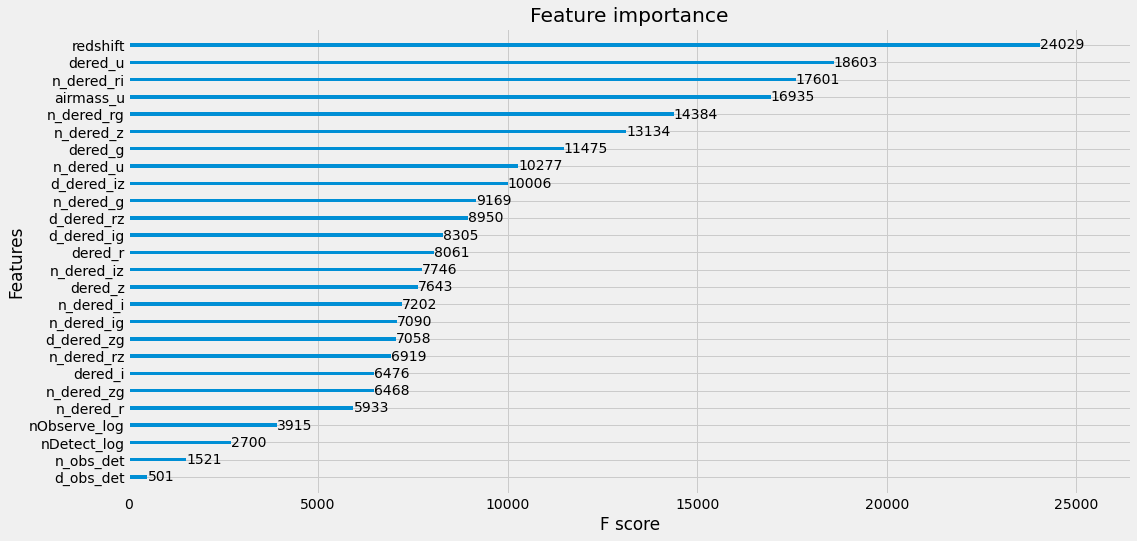

In [39]:
plot_importance(my_model)

In [41]:
y_pred =my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [42]:
mean_squared_error(y_test, y_pred)

0.066546875

In [43]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 93.54219%


In [44]:
Y_pred = my_model.predict(testX)
predictions = [round(value) for value in Y_pred]
predictions

[2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,


In [48]:
probas = my_model.predict_proba(testX)
np.round(probas,4)
df_probas = pd.DataFrame(np.round(probas,4))
df_probas.head(20)

,0,1,2
0,0.0000,0.2131,0.7869
1,1.0000,0.0000,0.0000
2,0.0000,0.0476,0.9524
3,1.0000,0.0000,0.0000
4,0.0000,0.0170,0.9830
5,0.0000,0.9563,0.0437
6,0.0000,0.8429,0.1571
7,0.0001,0.1327,0.8672
8,0.0000,0.1888,0.8112
9,0.0000,0.0513,0.9487


In [ ]:
for i in range(80000):
    if float(df_probas.iloc[i][0]) > 0.99 :
        print(test_sure.iloc[i])

In [ ]:
predictions = [ 1 if x >0.5 and x < 1.5 else ( 0 if x >-0.5 and x< 0.5 else 2) for x in predictions ]

In [49]:
# final result
submission['class'] = predictions
submission.to_csv("8020XGB_93,54_makedata_eta0115_minchild4.csv",index=False, encoding='utf-8-sig')